In [1]:
import pickle
import sympy as sp
import numpy as np

from IPython.display import display
from IPython.display import HTML

from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from plot_utils import *

In [2]:
# STSYEM CONSTANTS
l1, l2 = sp.symbols(["l1", "l2"])

# SYSTEM STATES
psi1, phi2 = sp.symbols(["\\psi_1", "\\phi_2"])
dpsi1, dphi2 = sp.symbols(["\\dot{\\psi_1}", "\\dot{\\phi_2}"])
ddpsi1, ddphi2 = sp.symbols(["\\ddot{\\psi_1}", "\\ddot{\\phi_2}"])

In [3]:
def rot_x(x):
    c = sp.cos(x)
    s = sp.sin(x)
    return sp.Matrix([
        [1, 0, 0],
        [0, c, s],
        [0, -s, c]
    ])

def rot_y(y):
    c = sp.cos(y)
    s = sp.sin(y)
    return sp.Matrix([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c]
    ])

def rot_z(z):
    c = sp.cos(z)
    s = sp.sin(z)
    return sp.Matrix([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1]
    ])

In [4]:
RI_1 = rot_z(psi1)
R1_I = RI_1.T

RI_2 = rot_x(phi2) @ RI_1
R2_I = RI_2.T

[x1, y1, z1] = R1_I @ sp.Matrix([l1, 0, 0])
[x2, y2, z2] = sp.Matrix([x1, y1, z1]) + R2_I @ sp.Matrix([0, 0, -l2])

In [5]:
with open("measurements_3d.pickle", "rb") as f:
    pts_arr = pickle.load(f)
    pts_arr = np.array(pts_arr)
with open("cam_params_3d.pickle", "rb") as f:
    [K_arr, R_arr, t_arr] = pickle.load(f)    
    K_arr = np.array(K_arr)
    R_arr = np.array(R_arr)
    t_arr = np.array(t_arr)
    
print(pts_arr.shape)
print("(cam, markers, N, xy)")

(2, 2, 400, 2)
(cam, markers, N, xy)


In [6]:
l1_val = 1
l2_val = 1
m1_val = 1
m2_val = 1

h = 0.02
(C, L, N, _) = pts_arr.shape

In [7]:
#ADD NOISE
pts_arr_noise = pts_arr + np.random.uniform(-50, 50, pts_arr.shape)

In [8]:
#OUTLIER REJECTING COST FUNCTION (REDESCENDING LOSS)
def func_step(start, x):
        return 1/(1+np.e**(-0.1*(x - start)))

def func_piece(start, end, x):
        return func_step(start, x) - func_step(end, x)
    
def redescending_loss(err, a, b, c):
    e = abs(err)
    cost = 0.0
    cost += (1 - func_step(a, e))/2*e**2
    cost += func_piece(a, b, e)*(a*e - (a**2)/2)
    cost += func_piece(b, c, e)*(a*b - (a**2)/2 + (a*(c-b)/2)*(1-((c-e)/(c-b))**2))
    cost += func_step(c, e)*(a*b - (a**2)/2 + (a*(c-b)/2))
    return cost

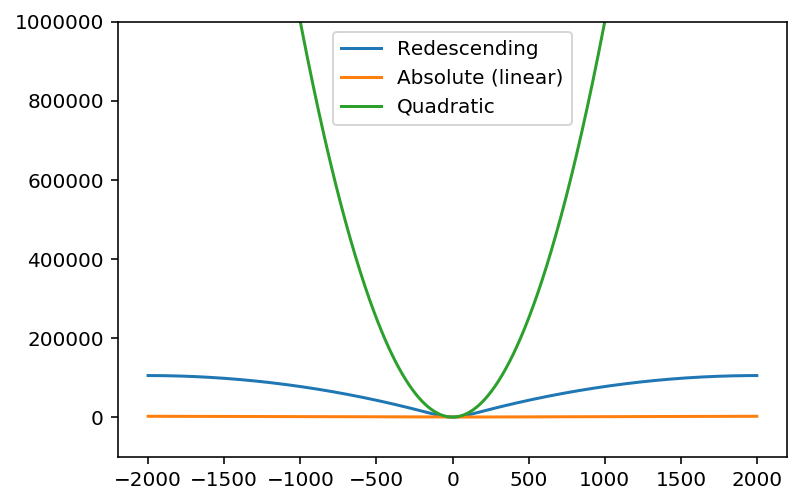

In [9]:
# PLOT OF REDESCENDING, ABSOLUTE AND QUADRATIC COST FUNCTIONS
# we use a redescending cost to stop outliers affecting the optimisation negatively

redesc_a = 100
redesc_b = 200
redesc_c = 2000

#Plot
r_x = np.arange(-2000,2000)
r_y1 = [redescending_loss(i, redesc_a, redesc_b, redesc_c) for i in r_x]
r_y2 = abs(r_x)
r_y3 = r_x**2
plt.plot(r_x,r_y1, label="Redescending")
plt.plot(r_x,r_y2, label="Absolute (linear)")
plt.plot(r_x,r_y3, label="Quadratic")
ax = plt.gca()
ax.set_ylim((-1e5, 1e6))
ax.legend()

In [10]:
m = ConcreteModel(name = "Pendulum from measurements")

# SETS
m.N = RangeSet(N) #number of points in trajectory
m.L = RangeSet(L) #number of links/markers
m.C = RangeSet(C) #number of cameras
m.D = RangeSet(2) #2D
m.CP = RangeSet(16) #number of camera parameters (fx, fy, cx, cy, r11, r12, r13, r21, r22, r23, r31, r32, r33, t1, t2, t3)

# PARAMETERS
m.g = Param(initialize=9.81) #gravity
m.h = Param(initialize=0.02) #timestep
m.m = Param(m.L, initialize=1.0) #mass of links
m.len = Param(m.L, initialize = 1.0) #length of links

def init_camera_params(m, c, cp):
    fx, fy, cx, cy = K_arr[c-1,0,0], K_arr[c-1,1,1], K_arr[c-1,0,2], K_arr[c-1,1,2]
    r = R_arr[c-1].flatten()
    t = t_arr[c-1].flatten()
    params = [fx, fy, cx, cy, *r, *t]
    return params[cp-1]
m.cp = Param(m.C, m.CP, initialize=init_camera_params) #camera parameters

def init_measurements(m,c,l,n,d):
#         return pts_arr[c-1, l-1, n-1, d-1]
    return pts_arr_noise[c-1, l-1, n-1, d-1]

m.meas = Param(m.C, m.L, m.N, m.D, initialize=init_measurements)

# WEIGHTS
m.meas_err_weight = Param(m.N, m.L, initialize=1e1)
m.model_err_weight = Param(initialize=1e2)


# VARIABLES
m.th = Var(m.N, m.L, within=Reals) #position
m.dth = Var(m.N, m.L, within=Reals) #velocity
m.ddth = Var(m.N, m.L, within=Reals) #acceleration
m.slack_model = Var(m.N, m.L)
m.slack_meas = Var(m.C, m.L, m.N, m.D)


# INTEGRATION CONSTRAINTS
def backwards_euler_pos(m,n,l): # for positions
    if n > 1:
        return m.th[n,l] == m.th[n-1,l] + m.h*m.dth[n,l]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to (i.e. the first point)
m.integrate_p = Constraint(m.N, m.L, rule = backwards_euler_pos)

def backwards_euler_vel(m,n,l): # for velocities
    if n > 1:
        return m.dth[n,l] == m.dth[n-1,l] + m.h*m.ddth[n,l]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.L, rule = backwards_euler_vel)


# MODEL CONSTRAINTS
#Constant acceleration model
def constant_acc(m, n, l):
    if n > 1:
        return m.ddth[n,l] == m.ddth[n-1,l] + m.slack_model[n,l]
    else:
        return Constraint.Skip 
m.constant_acc = Constraint(m.N, m.L, rule = constant_acc)


# MEASUREMENT CONSTRAINTS
func_map = {'sin':sin, 'cos':cos} 
sym_list_meas = [psi1, phi2, l1, l2]
lamb_x1 = sp.lambdify(sym_list_meas, x1, modules=[func_map])
lamb_y1 = sp.lambdify(sym_list_meas, y1, modules=[func_map])
lamb_z1 = sp.lambdify(sym_list_meas, z1, modules=[func_map])
lamb_x2 = sp.lambdify(sym_list_meas, x2, modules=[func_map])
lamb_y2 = sp.lambdify(sym_list_meas, y2, modules=[func_map])
lamb_z2 = sp.lambdify(sym_list_meas, z2, modules=[func_map])
lambs = [
    [lamb_x1, lamb_y1, lamb_z1],
    [lamb_x2, lamb_y2, lamb_z2],
]

def con_meas(m, c, l, n, d):
    #get 3d points
    var_list = [m.th[n,1], m.th[n,2], m.len[1], m.len[2]]
    x = lambs[l-1][0](*var_list)
    y = lambs[l-1][1](*var_list)
    z = lambs[l-1][2](*var_list)
    #project
    z_2d = x*m.cp[c,11] + y*m.cp[c,12] + z*m.cp[c,13] + m.cp[c,16]
    if d==1:
        x_2d = x*m.cp[c,5] + y*m.cp[c,6] + z*m.cp[c,7] + m.cp[c,14]
        u = m.cp[c,1]*x_2d/z_2d + m.cp[c,3]
        return u - m.meas[c,l,n,1] - m.slack_meas[c, l, n, 1] == 0
    else:
        y_2d = x*m.cp[c,8] + y*m.cp[c,9] + z*m.cp[c,10] + m.cp[c,15]
        v = m.cp[c,2]*y_2d/z_2d + m.cp[c,4]
        return v - m.meas[c,l,n,2] - m.slack_meas[c, l, n, 2] == 0
m.con_meas = Constraint(m.C, m.L, m.N, m.D, rule = con_meas)



#OBJECTIVE FUNCTION
def obj(m):
    slack_model_err = 0.0
    slack_meas_err = 0.0
    for n in range(1, N+1):
        for l in range(1, L+1):
            slack_model_err += m.model_err_weight * m.slack_model[n, l] ** 2
            for c in range (1, C+1):
                for d in range(1, 3):
                    slack_meas_err += m.meas_err_weight[n, l]*redescending_loss(m.slack_meas[c,l,n,d], redesc_a, redesc_b, redesc_c)
    return (slack_meas_err + slack_model_err)
m.obj = Objective(rule = obj)


# INITIALIZATION
for n in range(1,N+1):
    for l in range(1,3):
        m.th[n,l].value = 0
        m.dth[n,l].value = 0
        m.ddth[n,l].value = 0


In [11]:
# solving
opt = SolverFactory('ipopt')

# solver options
opt.options["print_level"] = 5
opt.options["max_iter"] = 30000
opt.options["max_cpu_time"] = 300
opt.options["tol"] = 1e-12
# opt.options["OF_print_frequency_time"] = 5

results = opt.solve(m, tee = False)

# For debugging:
print(results.solver.status)
print(results.solver.termination_condition)

ok
optimal


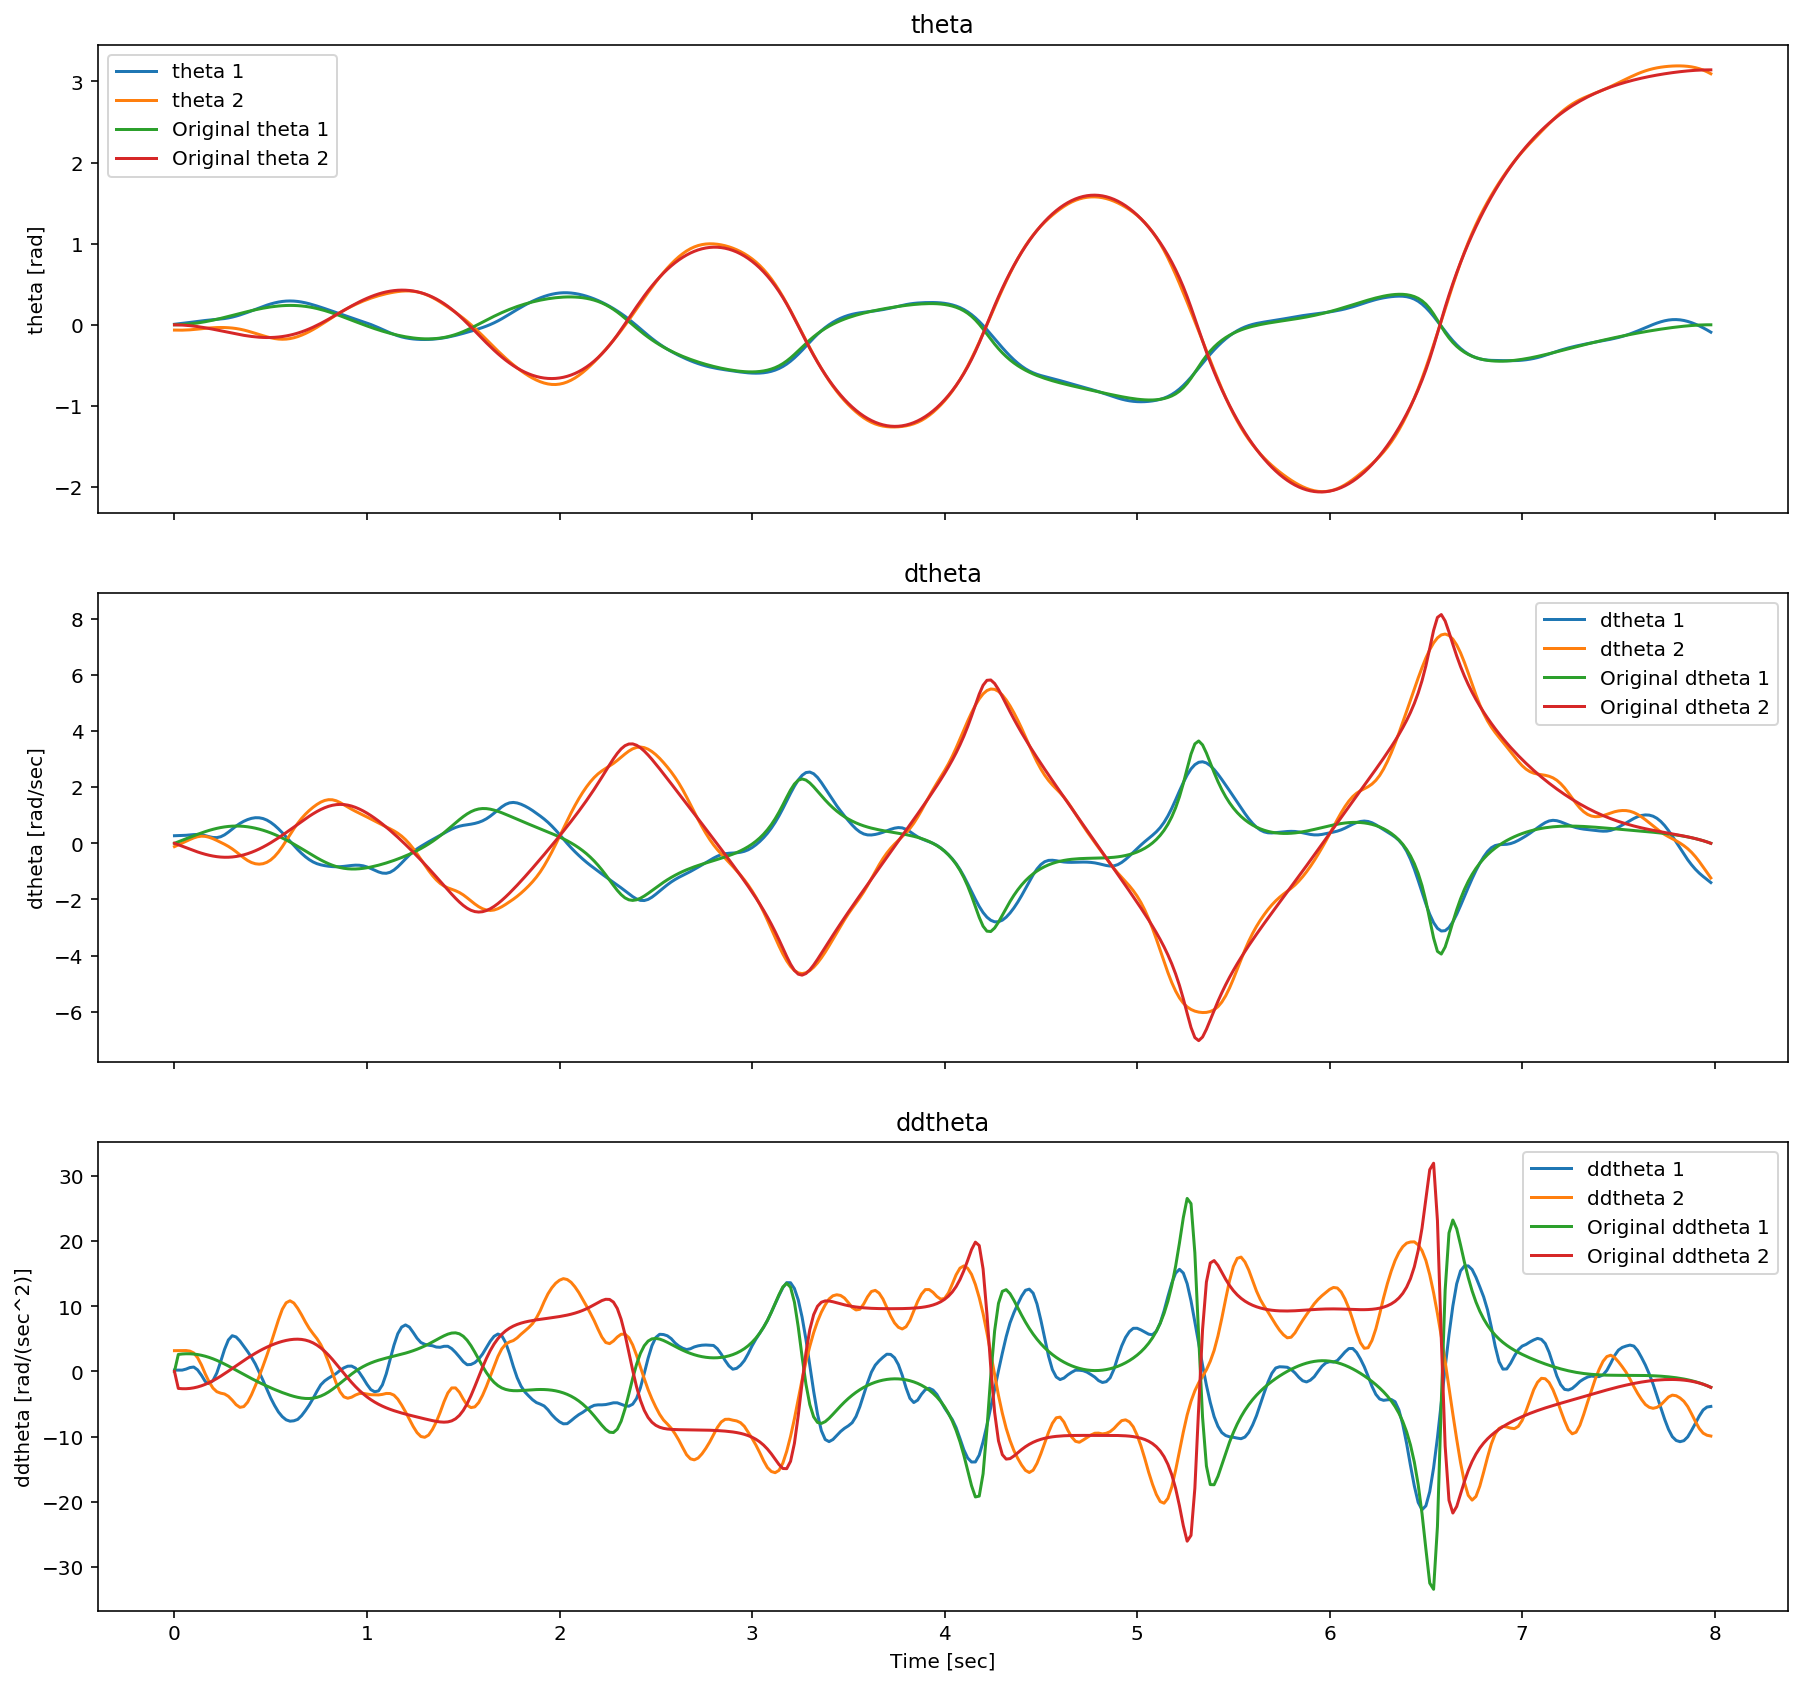

In [12]:
with open("states_3d.pickle", "rb") as f:
    [orig_theta_1, orig_theta_2, orig_dtheta_1, orig_dtheta_2, orig_ddtheta_1, orig_ddtheta_2, orig_torque] = pickle.load(f)

fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(13, 12), sharex=True) #create axes
fig.tight_layout(pad=3.0)
time = [i*h for i in range(N)]
plt.xlabel('Time [sec]')

#Pos
for i in range(1,3):
    theta = [m.th[(j, i)].value for j in range(1, N+1)]
    ax1.plot(time, theta, label=f"theta {i}")
ax1.plot(time, orig_theta_1, label="Original theta 1")
ax1.plot(time, orig_theta_2, label="Original theta 2")
ax1.set_ylabel('theta [rad]')
ax1.set_title('theta')
ax1.legend()

#Vel
for i in range(1,3):
    dtheta = [m.dth[(j, i)].value for j in range(1, N+1)]
    ax2.plot(time, dtheta, label=f"dtheta {i}")
ax2.plot(time, orig_dtheta_1, label="Original dtheta 1")
ax2.plot(time, orig_dtheta_2, label="Original dtheta 2")
ax2.set_ylabel('dtheta [rad/sec]')
ax2.set_title('dtheta')
ax2.legend()

#Acc    
for i in range(1,3):
    ddtheta = [m.ddth[(j, i)].value for j in range(1, N+1)]
    ax3.plot(time, ddtheta, label=f"ddtheta {i}")
ax3.plot(time, orig_ddtheta_1, label="Original ddtheta 1")
ax3.plot(time, orig_ddtheta_2, label="Original ddtheta 2")
ax3.set_ylabel('ddtheta [rad/(sec^2)]')
ax3.set_title('ddtheta')
ax3.legend()

In [13]:

fig = plt.figure(figsize=(10,10))
ax = plt.gca(projection='3d')

def plot_pendulum(i, m, ax):
    ax.clear()
    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    ax.set_zlim((-3, 3))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    psi1_val = m.th[i, 1].value
    phi2_val = m.th[i, 2].value
    l1_val = m.len[1]
    l2_val = m.len[2]
    
    x = [0, lamb_x1(psi1_val, phi2_val, l1_val, l2_val), lamb_x2(psi1_val, phi2_val, l1_val, l2_val)]
    y = [0, lamb_y1(psi1_val, phi2_val, l1_val, l2_val), lamb_y2(psi1_val, phi2_val, l1_val, l2_val)]
    z = [0, lamb_z1(psi1_val, phi2_val, l1_val, l2_val), lamb_z2(psi1_val, phi2_val, l1_val, l2_val)]

    plot_camera_axis(ax, np.eye(3), np.array([[0,0,0]]).T)
    plot_camera_axis(ax, R_arr[0], t_arr[0])
    plot_camera_axis(ax, R_arr[1], t_arr[1])
    ax.plot(x,y,z, linewidth=3, zorder=2)
    ax.plot(x, y, z, '.k', markersize=20, zorder=3)

    
update = lambda i: plot_pendulum(i, m, ax) #lambdify update function
animate = ani.FuncAnimation(fig, update, range(1, N+1), interval = m.h*1000, repeat=True)
plt.close('all')
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [14]:
def plot(m, c, l, th1, th2):
    #get 3d points
    var_list = [th1, th2, m.len[1], m.len[2]]
    x = lambs[l-1][0](*var_list)
    y = lambs[l-1][1](*var_list)
    z = lambs[l-1][2](*var_list)
    #project
    z_2d = x*m.cp[c,11] + y*m.cp[c,12] + z*m.cp[c,13] + m.cp[c,16]
    
    x_2d = x*m.cp[c,5] + y*m.cp[c,6] + z*m.cp[c,7] + m.cp[c,14]
    u = m.cp[c,1]*x_2d/z_2d + m.cp[c,3]

    y_2d = x*m.cp[c,8] + y*m.cp[c,9] + z*m.cp[c,10] + m.cp[c,15]
    v = m.cp[c,2]*y_2d/z_2d + m.cp[c,4]
    return u,v

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12, 6), sharex=True)
def plot_pendulum(i, m, axs):
    psi1_val = m.th[i, 1].value
    phi2_val = m.th[i, 2].value
    l1_val = m.len[1]
    l2_val = m.len[2]
    
    x = [0, lamb_x1(psi1_val, phi2_val, l1_val, l2_val), lamb_x2(psi1_val, phi2_val, l1_val, l2_val)]
    y = [0, lamb_y1(psi1_val, phi2_val, l1_val, l2_val), lamb_y2(psi1_val, phi2_val, l1_val, l2_val)]
    z = [0, lamb_z1(psi1_val, phi2_val, l1_val, l2_val), lamb_z2(psi1_val, phi2_val, l1_val, l2_val)]
    
    pts = np.vstack([x,y,z]).T.reshape((-1,3,1))
    
    for i, (k, r, t) in enumerate(zip(K_arr, R_arr, t_arr)):
        pts_2d = project(pts, k, r, t)
        axs[i].clear()
        axs[i].set_xlim((0, 1000))
        axs[i].set_ylim((1000, 0))
        axs[i].set_xlabel("X")
        axs[i].set_ylabel("Y")
        axs[i].plot(pts_2d[:,0],pts_2d[:,1], linewidth=3)
        axs[i].plot(pts_2d[:,0],pts_2d[:,1], '.k', markersize=20)
        
        #DEBUG
        xtest = [plot(m,i+1,1,psi1_val, phi2_val)[0], plot(m,i+1,2,psi1_val, phi2_val)[0]]
        ytest = [plot(m,i+1,1,psi1_val, phi2_val)[1], plot(m,i+1,2,psi1_val, phi2_val)[1]]
        axs[i].plot(xtest, ytest, c='r')
 
    
update = lambda i: plot_pendulum(i, m, axs)
animate = ani.FuncAnimation(fig, update, range(1, N+1), interval = m.h*1000, repeat=True)
plt.close('all')
HTML(animate.to_html5_video())